In [1]:
import pandas as pd
import numpy as np

import seaborn as sns ; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pickle

exec(open('justins_utils.py').read())
exec(open('justins_pipeline.py').read())

%matplotlib inline

# Setting Aside Test Data

In [4]:
# read in and preview postseason results
post_results_raw = pd.read_csv('Data/DataFiles/{}'.format('NCAATourneyCompactResults.csv'))
peek(post_results_raw)

dataframe shape = (2117, 8)


Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0

In [6]:
# only have team stats for recent postseason games
post_results_recent = post_results_raw[post_results_raw['Season'] >= 2003]
peek(post_results_recent)

# # Randomly choose n_tr indices that will be used to extract training set, rest go into test set
# n_tr = int(0.9*post_results_recent.shape[0])
# permut = np.random.permutation(post_results_recent.shape[0])
# permut_tr = permut[:n_tr]
# permut_tst = permut[n_tr:]

# # save permutations for later
# pickle.dump(permut_tr, open('pickles/permut_tr', 'wb'))
# pickle.dump(permut_tst, open('pickles/permut_tst', 'wb'))

# # extract training set and test set via indices that were just computed
# post_results_tr = post_results_recent.iloc[permut_tr]
# post_results_tst = post_results_recent.iloc[permut_tst]

post_results_tr = post_results_recent[post_results_recent['Season'] < 2017]
post_results_tst = post_results_recent[post_results_recent['Season'] == 2017]

peek(post_results_tst)

# save training and test sets, test set won't be touched until later
post_results_tr.to_csv('dataframes/post_results_tr.csv')
post_results_tst.to_csv('dataframes/post_results_tst.csv')

dataframe shape = (981, 8)


Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
1136    2003     134     1421      92     1411      84    N      1
1137    2003     136     1112      80     1436      51    N      0
1138    2003     136     1113      84     1272      71    N      0
1139    2003     136     1141      79     1166      73    N      0
1140    2003     136     1143      76     1301      74    N      1

dataframe shape = (67, 8)


Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
2050    2017     134     1243      95     1448      88    N      0
2051    2017     134     1291      67     1309      66    N      0
2052    2017     135     1413      67     1300      63    N      0
2053    2017     135     1425      75     1344      71    N      0
2054    2017     136     1112     100     1315      82    N      0

# Gathering Features

### Regular Season Data
get stats from regular season games, grouped by team

In [7]:
# open and preview RegularSeasonDetailedResults.csv
reg_results_raw = pd.read_csv('Data/DataFiles/RegularSeasonDetailedResults.csv')
peek(reg_results_raw)

dataframe shape = (76636, 34)


Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

  ...   LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0 ...      10    16    22   10   22     8   18     9     2   20  
1 ...      24     9    20   20   25     7   12     8     6   16  
2 ...      26    14    23   31   22     9   12     2     5   23  
3 ...      22     8    15   17   20     9   19     4     3   23  
4 ...      16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]

In [8]:
# get rid of data we won't be using
reg_stats = reg_results_raw.drop(columns=['DayNum', 'WLoc'])

# stats (grouped by team) summed up across all regular season wins
w_stats = (reg_stats.drop(columns=['LTeamID'])
                    .rename(columns={'WTeamID': 'TeamID'})
                    .rename(columns=lambda x: x[1:] + '_for'     if x[0] == 'W' else x)
                    .rename(columns=lambda x: x[1:] + '_against' if x[0] == 'L' else x)
                    .groupby(['Season', 'TeamID'])
                    .sum())

# stats (grouped by team) summed up across all regular season losses
l_stats = (reg_stats.drop(columns=['WTeamID'])
                    .rename(columns={'LTeamID': 'TeamID'})
                    .rename(columns=lambda x: x[1:] + '_for'     if x[0] == 'L' else x)
                    .rename(columns=lambda x: x[1:] + '_against' if x[0] == 'W' else x)
                    .groupby(['Season', 'TeamID'])
                    .sum())

# combine (add) stats from wins and losses
team_stats = w_stats + l_stats

# compute number of wins and losses
team_stats['Wins']   = reg_stats.groupby(['Season', 'WTeamID']).size().astype(int)
team_stats['Losses'] = reg_stats.groupby(['Season', 'LTeamID']).size().astype(int)

# reorganize columns
important_cols = ['Wins', 'Losses', 'Score_for', 'Score_against']
team_stats = team_stats[important_cols + [col for col in list(team_stats.columns) if col not in important_cols]]

peek(team_stats)

dataframe shape = (5130, 31)


Wins  Losses  Score_for  Score_against  Ast_against  Ast_for  \
Season TeamID                                                                 
2003   1102    12.0    16.0     1603.0         1596.0        256.0    364.0   
       1103    13.0    14.0     2127.0         2110.0        418.0    411.0   
       1104    17.0    11.0     1940.0         1820.0        327.0    339.0   
       1105     7.0    19.0     1866.0         1993.0        411.0    378.0   
       1106    13.0    15.0     1781.0         1785.0        330.0    327.0   

               Blk_against  Blk_for  DR_against  DR_for   ...    FTM_for  \
Season TeamID                                             ...              
2003   1102           44.0     50.0       564.0   471.0   ...      312.0   
       1103           77.0     63.0       595.0   538.0   ...      514.0   
       1104           89.0    106.0       634.0   670.0   ...      416.0   
       1105          109.0     54.0       686.0   601.0   ...      401.0   
       1106           89.0     88.0       626.0   668.0   ...      298.0   

               NumOT  OR_against  OR_for  PF_against  PF_for  Stl_against  \
Season TeamID                                                               
2003   1102      0.0       269.0   117.0       514.0   525.0        152.0   
       1103      8.0       325.0   264.0       606.0   536.0        173.0   
       1104      1.0       305.0   380.0       539.0   505.0        155.0   
       1105      4.0       343.0   351.0       496.0   526.0        244.0   
       1106      1.0       317.0   344.0       452.0   509.0        246.0   

               Stl_for  TO_against  TO_for  
Season TeamID                               
2003   1102      167.0       363.0   320.0  
       1103      196.0       414.0   341.0  
       1104      185.0       388.0   372.0  
       1105      242.0       489.0   485.0  
       1106      234.0       422.0   477.0  

[5 rows x 31 columns]

In [9]:
# Since not all teams play the same number of regular season games, change all relevant metrics to 'per game' metrics
team_stats_p_game = (team_stats.divide(team_stats['Wins'] + team_stats['Losses'], axis='index')
                                 .drop(columns=['Losses']))

peek(team_stats_p_game)

dataframe shape = (5130, 30)


Wins  Score_for  Score_against  Ast_against    Ast_for  \
Season TeamID                                                               
2003   1102    0.428571  57.250000      57.000000     9.142857  13.000000   
       1103    0.481481  78.777778      78.148148    15.481481  15.222222   
       1104    0.607143  69.285714      65.000000    11.678571  12.107143   
       1105    0.269231  71.769231      76.653846    15.807692  14.538462   
       1106    0.464286  63.607143      63.750000    11.785714  11.678571   

               Blk_against   Blk_for  DR_against     DR_for  FGA3_against  \
Season TeamID                                                               
2003   1102       1.571429  1.785714   20.142857  16.821429     12.428571   
       1103       2.851852  2.333333   22.037037  19.925926     18.370370   
       1104       3.178571  3.785714   22.642857  23.928571     19.142857   
       1105       4.192308  2.076923   26.384615  23.115385     17.538462   
       1106       3.178571  3.142857   22.357143  23.857143     15.214286   

                 ...        FTM_for     NumOT  OR_against     OR_for  \
Season TeamID    ...                                                   
2003   1102      ...      11.142857  0.000000    9.607143   4.178571   
       1103      ...      19.037037  0.296296   12.037037   9.777778   
       1104      ...      14.857143  0.035714   10.892857  13.571429   
       1105      ...      15.423077  0.153846   13.192308  13.500000   
       1106      ...      10.642857  0.035714   11.321429  12.285714   

               PF_against     PF_for  Stl_against   Stl_for  TO_against  \
Season TeamID                                                             
2003   1102     18.357143  18.750000     5.428571  5.964286   12.964286   
       1103     22.444444  19.851852     6.407407  7.259259   15.333333   
       1104     19.250000  18.035714     5.535714  6.607143   13.857143   
       1105     19.076923  20.230769     9.384615  9.307692   18.807692   
       1106     16.142857  18.178571     8.785714  8.357143   15.071429   

                  TO_for  
Season TeamID             
2003   1102    11.428571  
       1103    12.629630  
       1104    13.285714  
       1105    18.653846  
       1106    17.035714  

[5 rows x 30 columns]

### Seed Data

In [10]:
# Open and preview NCAATourneySeeds.csv
seeds_raw = pd.read_csv('Data/DataFiles/NCAATourneySeeds.csv')
peek(seeds_raw)

dataframe shape = (2150, 3)


Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

In [11]:
# prepare seeds index for merging
seeds = seeds_raw.set_index(['Season', 'TeamID'])

# convert seed data to int
seeds['Seed'] = seeds['Seed'].apply(lambda x: x[1:3]).astype(int)

peek(seeds)

dataframe shape = (2150, 1)


Seed
Season TeamID      
1985   1207       1
       1210       2
       1228       3
       1260       4
       1374       5

### Ordinal Ranking Data

In [12]:
# read in and preview MasseyOrdinals.csv
ordinals_raw = pd.read_csv('Data/DataFiles/MasseyOrdinals.csv')
peek(ordinals_raw)

dataframe shape = (3200201, 5)


Season  RankingDayNum SystemName  TeamID  OrdinalRank
0    2003             35        SEL    1102          159
1    2003             35        SEL    1103          229
2    2003             35        SEL    1104           12
3    2003             35        SEL    1105          314
4    2003             35        SEL    1106          260

In [13]:
# find out how many ranking systems we have
ordinals_raw['SystemName'].unique().size

159

won't be using all of these, need to find a way to condense into fewer features

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


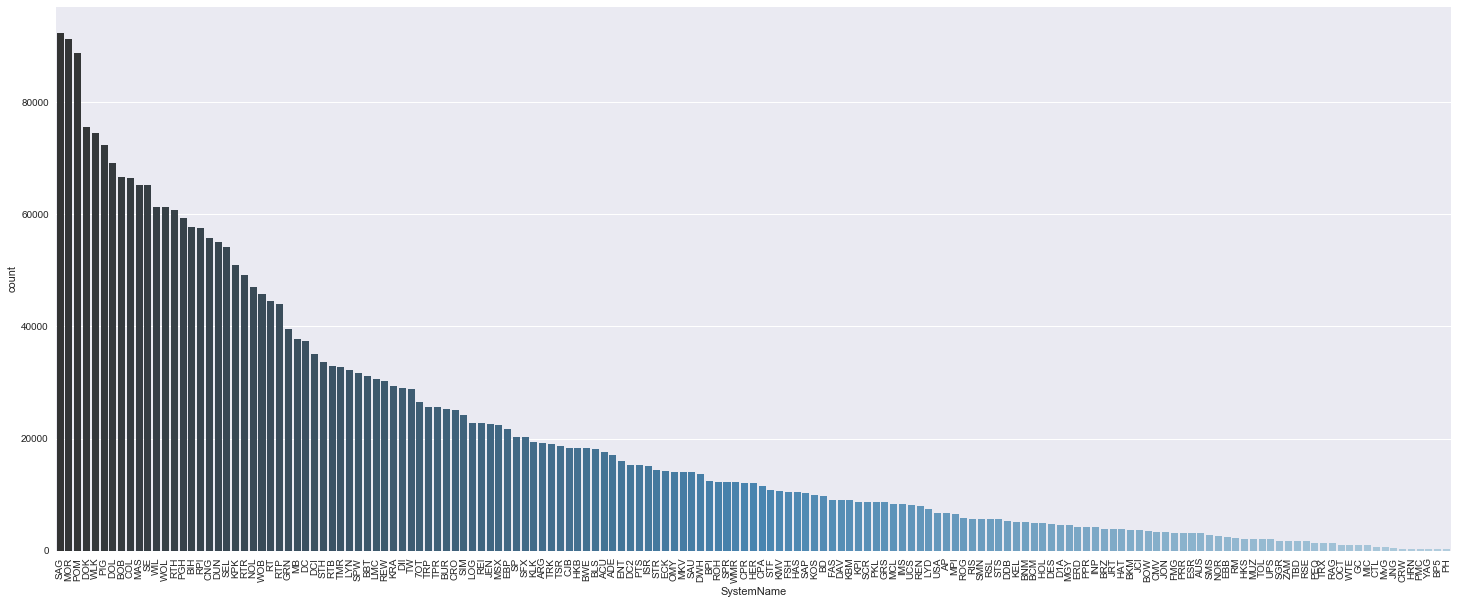

In [14]:
# check distribution of rankings from each ranking system
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.countplot(ordinals_raw['SystemName'], order=ordinals_raw['SystemName'].value_counts().index, palette='Blues_d');
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);

In [15]:
# instead of using ordinal ranks from different days as distinct features, would like to have one feature per ranking system
# probably a bad idea to use a moving average because of missing data
# will use a weighted average, so that rankings at later dates have greater importance, while avoiding unpredictability from missing data

def w_avg(group, val_col, weight_col):
    w = group[weight_col].transpose() / group[weight_col].sum()
    v = group[val_col]
    
    return w.dot(v)

In [16]:
# get weighted average of each system ranking for each team
ordinals_all = (pd.DataFrame(ordinals_raw.groupby(['Season', 'TeamID', 'SystemName'])
                                         .apply(w_avg, 'OrdinalRank', 'RankingDayNum'),        # return weighted average of each grouping
                            columns=['WeightedOrdinal'])
                .unstack(level=-1)['WeightedOrdinal'])                                         # each unique ranking system is a feature

peek(ordinals_all)

dataframe shape = (5130, 159)


SystemName     7OT  ACU  ADE         AP         ARG  AUS  BBT  BCM  BD  \
Season TeamID                                                            
2003   1102    NaN  NaN  NaN        NaN  125.029657  NaN  NaN  NaN NaN   
       1103    NaN  NaN  NaN        NaN  183.674699  NaN  NaN  NaN NaN   
       1104    NaN  NaN  NaN  10.919244   30.998146  NaN  NaN  NaN NaN   
       1105    NaN  NaN  NaN        NaN  303.329008  NaN  NaN  NaN NaN   
       1106    NaN  NaN  NaN        NaN  230.635774  NaN  NaN  NaN NaN   

SystemName            BIH ...   UPS       USA  WIL         WLK  WMR  \
Season TeamID             ...                                         
2003   1102    155.236904 ...   NaN       NaN  NaN  137.507428  NaN   
       1103    190.096951 ...   NaN       NaN  NaN  183.237686  NaN   
       1104     23.185301 ...   NaN  10.80756  NaN   27.241595  NaN   
       1105    306.724785 ...   NaN       NaN  NaN  303.179828  NaN   
       1106    253.882721 ...   NaN       NaN  NaN  231.845973  NaN   

SystemName            WOB         WOL         WTE  YAG  ZAM  
Season TeamID                                                
2003   1102    151.450352  155.565138  145.396226  NaN  NaN  
       1103    191.684128  177.256881  161.264151  NaN  NaN  
       1104     25.192338   28.032110   29.207547  NaN  NaN  
       1105    303.148554  309.499083  302.207547  NaN  NaN  
       1106    246.030493  250.585321  249.018868  NaN  NaN  

[5 rows x 159 columns]

In [17]:
# lots of missing data - drop metrics missing rankings for > 100 teams
ordinals = ordinals_all.dropna(axis=1, thresh=ordinals_all.shape[0]-100)

peek(ordinals)

dataframe shape = (5130, 9)


SystemName            COL         DOL         MOR         POM         RPI  \
Season TeamID                                                               
2003   1102    159.070976  163.629114  131.502737  146.382330  159.114934   
       1103    180.577947  180.432911  151.257232  177.533229  201.351837   
       1104     38.839037   31.853165   24.326818   28.663018   23.472244   
       1105    311.555133  315.322785  302.562158  311.337764  309.197029   
       1106    241.923954  249.324051  272.516028  239.927287  243.069586   

SystemName            RTH         SAG         WLK         WOL  
Season TeamID                                                  
2003   1102    148.910102  133.860829  137.507428  155.565138  
       1103    174.759036  179.930414  183.237686  177.256881  
       1104     25.484708   30.711493   27.241595   28.032110  
       1105    311.319741  311.312744  303.179828  309.499083  
       1106    258.096386  254.766224  231.845973  250.585321

### Conference Data

In [18]:
# read in and preview TeamConferences.csv
confs_raw = pd.read_csv('Data/DataFiles/TeamConferences.csv')

peek(confs_raw)

dataframe shape = (10888, 3)


Season  TeamID ConfAbbrev
0    1985    1114      a_sun
1    1985    1147      a_sun
2    1985    1204      a_sun
3    1985    1209      a_sun
4    1985    1215      a_sun

In [19]:
# one-hot encoding
confs = pd.get_dummies(confs_raw.rename(columns={'Season': 'season', 'TeamID': 'team_id', 'ConfAbbrev': 'conf'}).set_index(['season', 'team_id'])['conf'])

peek(confs)

dataframe shape = (10888, 51)


a_sun  a_ten  aac  acc  aec  asc  awc  big_east  big_eight  \
season team_id                                                               
1985   1114         1      0    0    0    0    0    0         0          0   
       1147         1      0    0    0    0    0    0         0          0   
       1204         1      0    0    0    0    0    0         0          0   
       1209         1      0    0    0    0    0    0         0          0   
       1215         1      0    0    0    0    0    0         0          0   

                big_sky ...   pcaa  sec  southern  southland  summit  \
season team_id          ...                                            
1985   1114           0 ...      0    0         0          0       0   
       1147           0 ...      0    0         0          0       0   
       1204           0 ...      0    0         0          0       0   
       1209           0 ...      0    0         0          0       0   
       1215           0 ...      0    0         0          0       0   

                sun_belt  swac  swc  wac  wcc  
season team_id                                 
1985   1114            0     0    0    0    0  
       1147            0     0    0    0    0  
       1204            0     0    0    0    0  
       1209            0     0    0    0    0  
       1215            0     0    0    0    0  

[5 rows x 51 columns]

although specific team conferences do probably carry some predictive power, including these in the data would result in 51*2 = 102 additional features for each game. Avoiding adding these in for now

### Merging Collected Data

In [23]:
team_stats_all = (team_stats_p_game.merge(seeds,    how='left', left_index=True, right_index=True)
                                   .merge(ordinals, how='left', left_index=True, right_index=True)
#                                  .merge(confs   , how='left', left_index=True, right_index=True)
                 )

# will need this again when we process test data
team_stats_all.to_csv('dataframes/team_stats_all.csv')

peek(team_stats_all)

dataframe shape = (5130, 40)


Wins  Score_for  Score_against  Ast_against    Ast_for  \
Season TeamID                                                               
2003   1102    0.428571  57.250000      57.000000     9.142857  13.000000   
       1103    0.481481  78.777778      78.148148    15.481481  15.222222   
       1104    0.607143  69.285714      65.000000    11.678571  12.107143   
       1105    0.269231  71.769231      76.653846    15.807692  14.538462   
       1106    0.464286  63.607143      63.750000    11.785714  11.678571   

               Blk_against   Blk_for  DR_against     DR_for  FGA3_against  \
Season TeamID                                                               
2003   1102       1.571429  1.785714   20.142857  16.821429     12.428571   
       1103       2.851852  2.333333   22.037037  19.925926     18.370370   
       1104       3.178571  3.785714   22.642857  23.928571     19.142857   
       1105       4.192308  2.076923   26.384615  23.115385     17.538462   
       1106       3.178571  3.142857   22.357143  23.857143     15.214286   

                  ...      Seed         COL         DOL         MOR  \
Season TeamID     ...                                                 
2003   1102       ...       NaN  159.070976  163.629114  131.502737   
       1103       ...       NaN  180.577947  180.432911  151.257232   
       1104       ...      10.0   38.839037   31.853165   24.326818   
       1105       ...       NaN  311.555133  315.322785  302.562158   
       1106       ...       NaN  241.923954  249.324051  272.516028   

                      POM         RPI         RTH         SAG         WLK  \
Season TeamID                                                               
2003   1102    146.382330  159.114934  148.910102  133.860829  137.507428   
       1103    177.533229  201.351837  174.759036  179.930414  183.237686   
       1104     28.663018   23.472244   25.484708   30.711493   27.241595   
       1105    311.337764  309.197029  311.319741  311.312744  303.179828   
       1106    239.927287  243.069586  258.096386  254.766224  231.845973   

                      WOL  
Season TeamID              
2003   1102    155.565138  
       1103    177.256881  
       1104     28.032110  
       1105    309.499083  
       1106    250.585321  

[5 rows x 40 columns]

In [24]:
# add team stats to results
reg_results  = results_processing(reg_results_raw, team_stats_all, save_name='reg_results')
post_results = results_processing(post_results_tr, team_stats_all, save_name='post_results')

peek(post_results)

dataframe shape = (914, 81)


y    l_Wins  l_Score_for  l_Score_against  l_Ast_against  l_Ast_for  \
1136  0  0.600000    72.800000        70.833333      13.766667  14.200000   
1137  1  0.892857    85.214286        70.250000      15.464286  17.642857   
1138  1  0.620690    75.965517        69.172414      14.068966  15.551724   
1139  1  0.793103    79.344828        73.241379      11.793103  15.620690   
1140  1  0.724138    74.482759        69.758621      16.034483  16.000000   

      l_Blk_against  l_Blk_for  l_DR_against   l_DR_for     ...      h_Seed  \
1136       2.600000   2.233333     22.866667  24.800000     ...        16.0   
1137       2.392857   4.214286     23.285714  27.642857     ...        16.0   
1138       3.931034   4.241379     20.551724  23.310345     ...         7.0   
1139       2.482759   4.000000     18.896552  23.275862     ...         6.0   
1140       2.517241   2.793103     23.000000  24.379310     ...         9.0   

           h_COL       h_DOL       h_MOR       h_POM       h_RPI       h_RTH  \
1136  226.309252  254.534177  274.815481  264.986708  201.321345  249.208526   
1137  162.096324  174.382278  195.154808  163.744332  168.586396  190.718258   
1138   28.564005   38.137975   35.954652   44.028147   37.129007   31.951807   
1139   22.242079   19.293671   23.308053   18.466771   30.988272   18.369787   
1140   63.281369   57.573418   33.411259   53.377639   64.807662   49.262280   

           h_SAG       h_WLK       h_WOL  
1136  249.322127  228.307271  224.515596  
1137  164.899922  175.523847  187.943119  
1138   45.297889   43.358092   31.177064  
1139   12.623925   14.649726   15.482569  
1140   53.491009   62.162627   54.671560  

[5 rows x 81 columns]

# Data Exploration

In [73]:
post_results.describe()

y      l_Wins  l_Score_for  l_Score_against  l_Ast_against  \
count  882.000000  882.000000   882.000000       882.000000     882.000000   
mean     0.487528    0.751407    74.482846        65.277976      12.018652   
std      0.500128    0.104245     5.263478         4.431170       1.461903   
min      0.000000    0.366667    58.812500        50.428571       8.321429   
25%      0.000000    0.686161    70.795588        62.213996      11.029412   
50%      0.000000    0.757576    74.530331        65.233333      11.939394   
75%      1.000000    0.821429    78.392857        68.172991      12.838710   
max      1.000000    0.970588    89.387097        78.516129      17.625000   

        l_Ast_for  l_Blk_against   l_Blk_for  l_DR_against    l_DR_for  \
count  882.000000     882.000000  882.000000    882.000000  882.000000   
mean    14.665612       3.174369    4.118745     21.909708   24.762413   
std      1.835835       0.594897    1.355673      1.789958    1.933665   
min      9.411765       1.451613    0.655172     15.733333   15.357143   
25%     13.368750       2.741935    3.212121     20.677419   23.535534   
50%     14.665612       3.140394    3.966667     21.876894   24.666667   
75%     15.831897       3.531250    4.870968     23.148438   26.092371   
max     19.322581       5.593750    9.333333     28.969697   30.939394   

          ...          h_Seed       h_COL       h_DOL       h_MOR       h_POM  \
count     ...      882.000000  882.000000  882.000000  882.000000  882.000000   
mean      ...        6.799320   42.069189   42.269540   44.892019   43.783230   
std       ...        4.576687   48.271374   48.659835   54.411263   51.124175   
min       ...        1.000000    1.000000    1.000000    1.041946    1.023581   
25%       ...        3.000000   12.036755   11.557692   12.329403   12.329403   
50%       ...        6.000000   25.800310   25.930457   24.404672   25.785614   
75%       ...       11.000000   50.878106   51.581743   51.322255   51.845134   
max       ...       16.000000  271.107739  270.090641  291.249816  269.447307   

            h_RPI       h_RTH       h_SAG       h_WLK       h_WOL  
count  882.000000  882.000000  882.000000  882.000000  882.000000  
mean    41.694782   43.374026   43.361196   42.073187   42.097055  
std     47.001877   52.146478   50.939825   48.818527   47.571873  
min      1.000000    1.000000    1.114959    1.000000    1.000000  
25%     12.368674   11.662377   11.510458   12.524952   12.064879  
50%     27.546762   24.103143   26.522476   25.446284   25.596618  
75%     49.587002   49.240985   49.923952   48.369544   50.237875  
max    288.079380  282.464533  262.809663  276.534901  262.465398  

[8 rows x 81 columns]

In [66]:
# normalize data: mean=0, SD=1
post_norm = post_results.apply(lambda x: (x - x.mean()) / x.std())
reg_norm  =  reg_results.apply(lambda x: (x - x.mean()) / x.std())

# reset y values
post_norm['y'] = post_results['y']
reg_norm['y']  = reg_results['y']

post_norm.describe()

y        l_Wins   l_Score_for  l_Score_against  l_Ast_against  \
count  882.000000  8.820000e+02  8.820000e+02     8.820000e+02   8.820000e+02   
mean     0.487528 -1.732804e-15  1.430916e-14    -1.014054e-14   1.932191e-15   
std      0.500128  1.000000e+00  1.000000e+00     1.000000e+00   1.000000e+00   
min      0.000000 -3.690738e+00 -2.977185e+00    -3.351125e+00  -2.529048e+00   
25%      0.000000 -6.258942e-01 -7.005363e-01    -6.914607e-01  -6.766796e-01   
50%      0.000000  5.917635e-02  9.021583e-03    -1.007469e-02  -5.421542e-02   
75%      1.000000  6.717039e-01  7.428569e-01     6.533297e-01   5.609525e-01   
max      1.000000  2.102563e+00  2.831635e+00     2.987507e+00   3.834966e+00   

          l_Ast_for  l_Blk_against     l_Blk_for  l_DR_against      l_DR_for  \
count  8.820000e+02   8.820000e+02  8.820000e+02  8.820000e+02  8.820000e+02   
mean   2.954804e-15   8.703041e-15  2.636525e-15 -2.392140e-15 -7.172141e-15   
std    1.000000e+00   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.861830e+00  -2.895888e+00 -2.554872e+00 -3.450570e+00 -4.863960e+00   
25%   -7.064153e-01  -7.269043e-01 -6.687624e-01 -6.884458e-01 -6.344835e-01   
50%   -9.676017e-16  -5.711034e-02 -1.121789e-01 -1.833250e-02 -4.951545e-02   
75%    6.352885e-01   5.999037e-01  5.548706e-01  6.920437e-01  6.877914e-01   
max    2.536704e+00   4.066889e+00  3.846494e+00  3.944220e+00  3.194442e+00   

           ...             h_Seed         h_COL         h_DOL         h_MOR  \
count      ...       8.820000e+02  8.820000e+02  8.820000e+02  8.820000e+02   
mean       ...      -2.148697e-16  9.767949e-17 -1.213441e-16  2.107032e-15   
std        ...       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min        ...      -1.267144e+00 -8.507980e-01 -8.481233e-01 -8.059007e-01   
25%        ...      -8.301463e-01 -6.221582e-01 -6.311540e-01 -5.984536e-01   
50%        ...      -1.746503e-01 -3.370295e-01 -3.357817e-01 -3.765277e-01   
75%        ...       9.178431e-01  1.824874e-01  1.913735e-01  1.181784e-01   
max        ...       2.010337e+00  4.744811e+00  4.681913e+00  4.527699e+00   

              h_POM         h_RPI         h_RTH         h_SAG         h_WLK  \
count  8.820000e+02  8.820000e+02  8.820000e+02  8.820000e+02  8.820000e+02   
mean  -5.110550e-16  6.520987e-16  3.655428e-16  7.407781e-17  1.586033e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -8.363880e-01 -8.658119e-01 -8.125961e-01 -8.293361e-01 -8.413442e-01   
25%   -6.152437e-01 -6.239348e-01 -6.081264e-01 -6.252620e-01 -6.052668e-01   
50%   -3.520373e-01 -3.010097e-01 -3.695529e-01 -3.305610e-01 -3.405859e-01   
75%    1.576926e-01  1.679129e-01  1.125092e-01  1.288335e-01  1.289748e-01   
max    4.414038e+00  5.242016e+00  4.584979e+00  4.307994e+00  4.802720e+00   

              h_WOL  
count  8.820000e+02  
mean   7.633098e-16  
std    1.000000e+00  
min   -8.638940e-01  
25%   -6.313011e-01  
50%   -3.468528e-01  
75%    1.711267e-01  
max    4.632324e+00  

[8 rows x 81 columns]

In [67]:
from sklearn.feature_selection import f_classif

def get_f_scores(df):
    X = df[df.columns.difference(['y'])]
    y = df['y']
    
    f_scores, p_vals = f_classif(X, y)
    
    return pd.DataFrame(np.column_stack((f_scores, p_vals)), index=X.columns, columns=['f_score', 'p_val']).sort_values(by='f_score', ascending=False)

In [69]:
print('Regular Season F-Scores')
display(get_f_scores(reg_norm.sample(800)).head(20).T)
print('Post Season F-Scores')
display(get_f_scores(post_norm.sample(800)).head(20).T)

Regular Season F-Scores


h_Wins        l_Wins         h_WOL         h_DOL         h_RPI  \
f_score  1.684933e+02  1.200949e+02  1.186508e+02  1.149234e+02  1.146558e+02   
p_val    4.289249e-35  3.944137e-26  7.429961e-26  3.827977e-25  4.307413e-25   

                h_COL         h_WLK         h_SAG         h_POM         l_WLK  \
f_score  1.137713e+02  1.116928e+02  1.032353e+02  1.014865e+02  9.950435e+01   
p_val    6.363226e-25  1.594327e-24  6.853630e-23  1.498710e-22  3.645153e-22   

                l_RPI         h_RTH         l_WOL         l_COL         l_DOL  \
f_score  9.700592e+01  9.410470e+01  9.390108e+01  9.288450e+01  9.271917e+01   
p_val    1.120924e-21  4.149115e-21  4.549069e-21  7.204615e-21  7.764449e-21   

                l_SAG         l_POM         l_RTH         h_MOR         l_MOR  
f_score  9.067480e+01  8.802001e+01  8.403387e+01  8.352472e+01  7.637982e+01  
p_val    1.961230e-20  6.555861e-20  4.044280e-19  5.105765e-19  1.366055e-17

Post Season F-Scores


l_Seed         l_MOR        h_Seed         l_SAG         l_POM  \
f_score  1.983156e+02  1.328850e+02  1.233271e+02  1.209386e+02  1.200960e+02   
p_val    2.177397e-40  1.513388e-28  9.595318e-27  2.725763e-26  3.942354e-26   

                l_WLK         l_RTH         l_COL         l_WOL         l_DOL  \
f_score  1.179615e+02  1.175600e+02  1.125382e+02  1.121642e+02  1.121435e+02   
p_val    1.005574e-25  1.199570e-25  1.097041e-24  1.294274e-24  1.306179e-24   

                l_RPI        l_Wins         h_MOR         h_RTH         h_POM  \
f_score  1.093084e+02  9.639001e+01  7.826044e+01  7.465187e+01  7.340160e+01   
p_val    4.585757e-24  1.479348e-21  5.734334e-18  3.038551e-17  5.424693e-17   

                h_SAG         h_WLK         h_DOL         h_COL         h_WOL  
f_score  7.111567e+01  6.788246e+01  6.122545e+01  6.037003e+01  5.884195e+01  
p_val    1.569155e-16  7.088040e-16  1.614315e-14  2.417336e-14  4.978539e-14

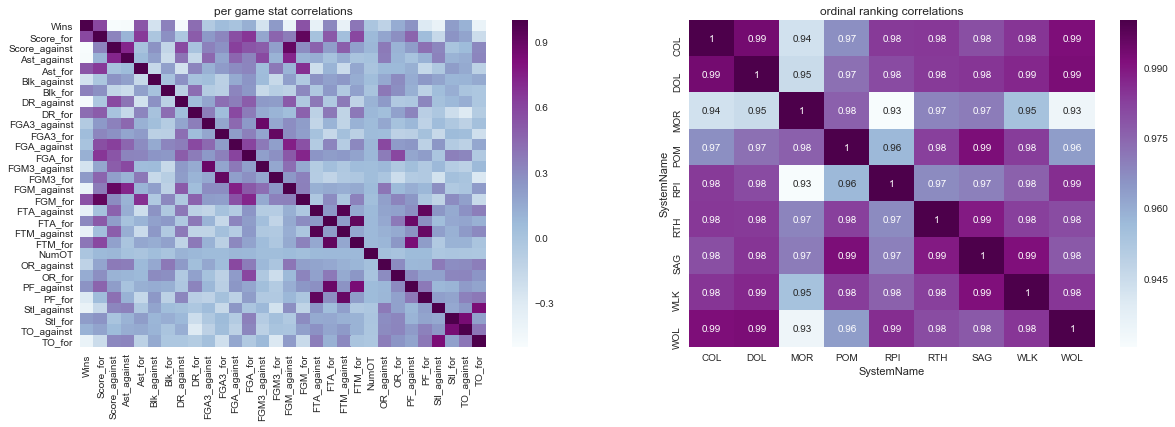

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.heatmap(team_stats_p_game.corr(), cmap='BuPu', ax=ax1);
sns.heatmap(ordinals.corr(), cmap='BuPu', annot=True, ax=ax2);

ax1.set(title='per game stat correlations');
ax2.set(title='ordinal ranking correlations');

ordinal rankings are heavily correlated, will probably help to average them or to take principal components to reduce input dimensionality

In [71]:
# getting list of ordinal names
ordinal_cols = list(ordinals.columns)
h_ordinal_cols = ['h_' + sys for sys in ordinal_cols]
l_ordinal_cols = ['l_' + sys for sys in ordinal_cols]

# look at f-scores without ordinal rankings
reg_f_scores  = get_f_scores(reg_norm.sample(800).drop(columns=h_ordinal_cols + l_ordinal_cols)).head(20).T
post_f_scores = get_f_scores(post_norm.sample(800).drop(columns=h_ordinal_cols + l_ordinal_cols)).head(20).T

print('Regular Season F-Scores')
display(reg_f_scores)
print('Post Season F-Scores')
display(post_f_scores)

Regular Season F-Scores


l_Wins        h_Wins   h_Score_for     h_FGM_for     l_Blk_for  \
f_score  1.283823e+02  1.120827e+02  5.056084e+01  4.873758e+01  4.790364e+01   
p_val    1.062852e-27  1.341792e-24  2.568597e-12  6.160822e-12  9.199840e-12   

            l_Ast_for     l_FGM_for   l_Score_for  l_Ast_against  \
f_score  4.065975e+01  3.556947e+01  3.543253e+01   2.994410e+01   
p_val    3.064515e-10  3.695582e-09  3.952889e-09   5.956207e-08   

            h_Ast_for  l_Score_against  h_Blk_for  l_Stl_for  l_DR_against  \
f_score  2.837783e+01     2.770138e+01  23.593451  23.521186     22.745625   
p_val    1.299146e-07     1.820962e-07   0.000001   0.000001      0.000002   

          h_TO_for  h_FTM_for  l_FGM_against  l_Blk_against   l_DR_for  \
f_score  18.981375  18.551262      18.152536      15.809817  15.806809   
p_val     0.000015   0.000019       0.000023       0.000076   0.000077   

         h_Stl_for  
f_score  15.082684  
p_val     0.000111

Post Season F-Scores


l_Seed        h_Seed        l_Wins     l_FGM_for     l_Ast_for  \
f_score  2.176847e+02  1.364377e+02  9.940560e+01  4.142884e+01  3.081788e+01   
p_val    9.675125e-44  3.273842e-29  3.810402e-22  2.107822e-10  3.859465e-08   

         l_Score_against     h_FGM_for     l_Blk_for  l_FTM_against  \
f_score     2.951797e+01  2.943781e+01  2.753332e+01   2.735226e+01   
p_val       7.362038e-08  7.661622e-08  1.980473e-07   2.168075e-07   

          l_Score_for        h_Wins  h_FGA_for   l_PF_for  h_Score_for  \
f_score  2.629249e+01  2.545233e+01  24.231129  24.172115    23.581054   
p_val    3.685330e-07  5.617643e-07   0.000001   0.000001     0.000001   

         l_FTA_against  l_DR_against   l_DR_for   l_OR_for  h_Blk_for  \
f_score      22.802757     19.485483  19.471902  18.783051  16.956536   
p_val         0.000002      0.000012   0.000012   0.000017   0.000042   

          h_OR_for  
f_score  14.074787  
p_val     0.000188

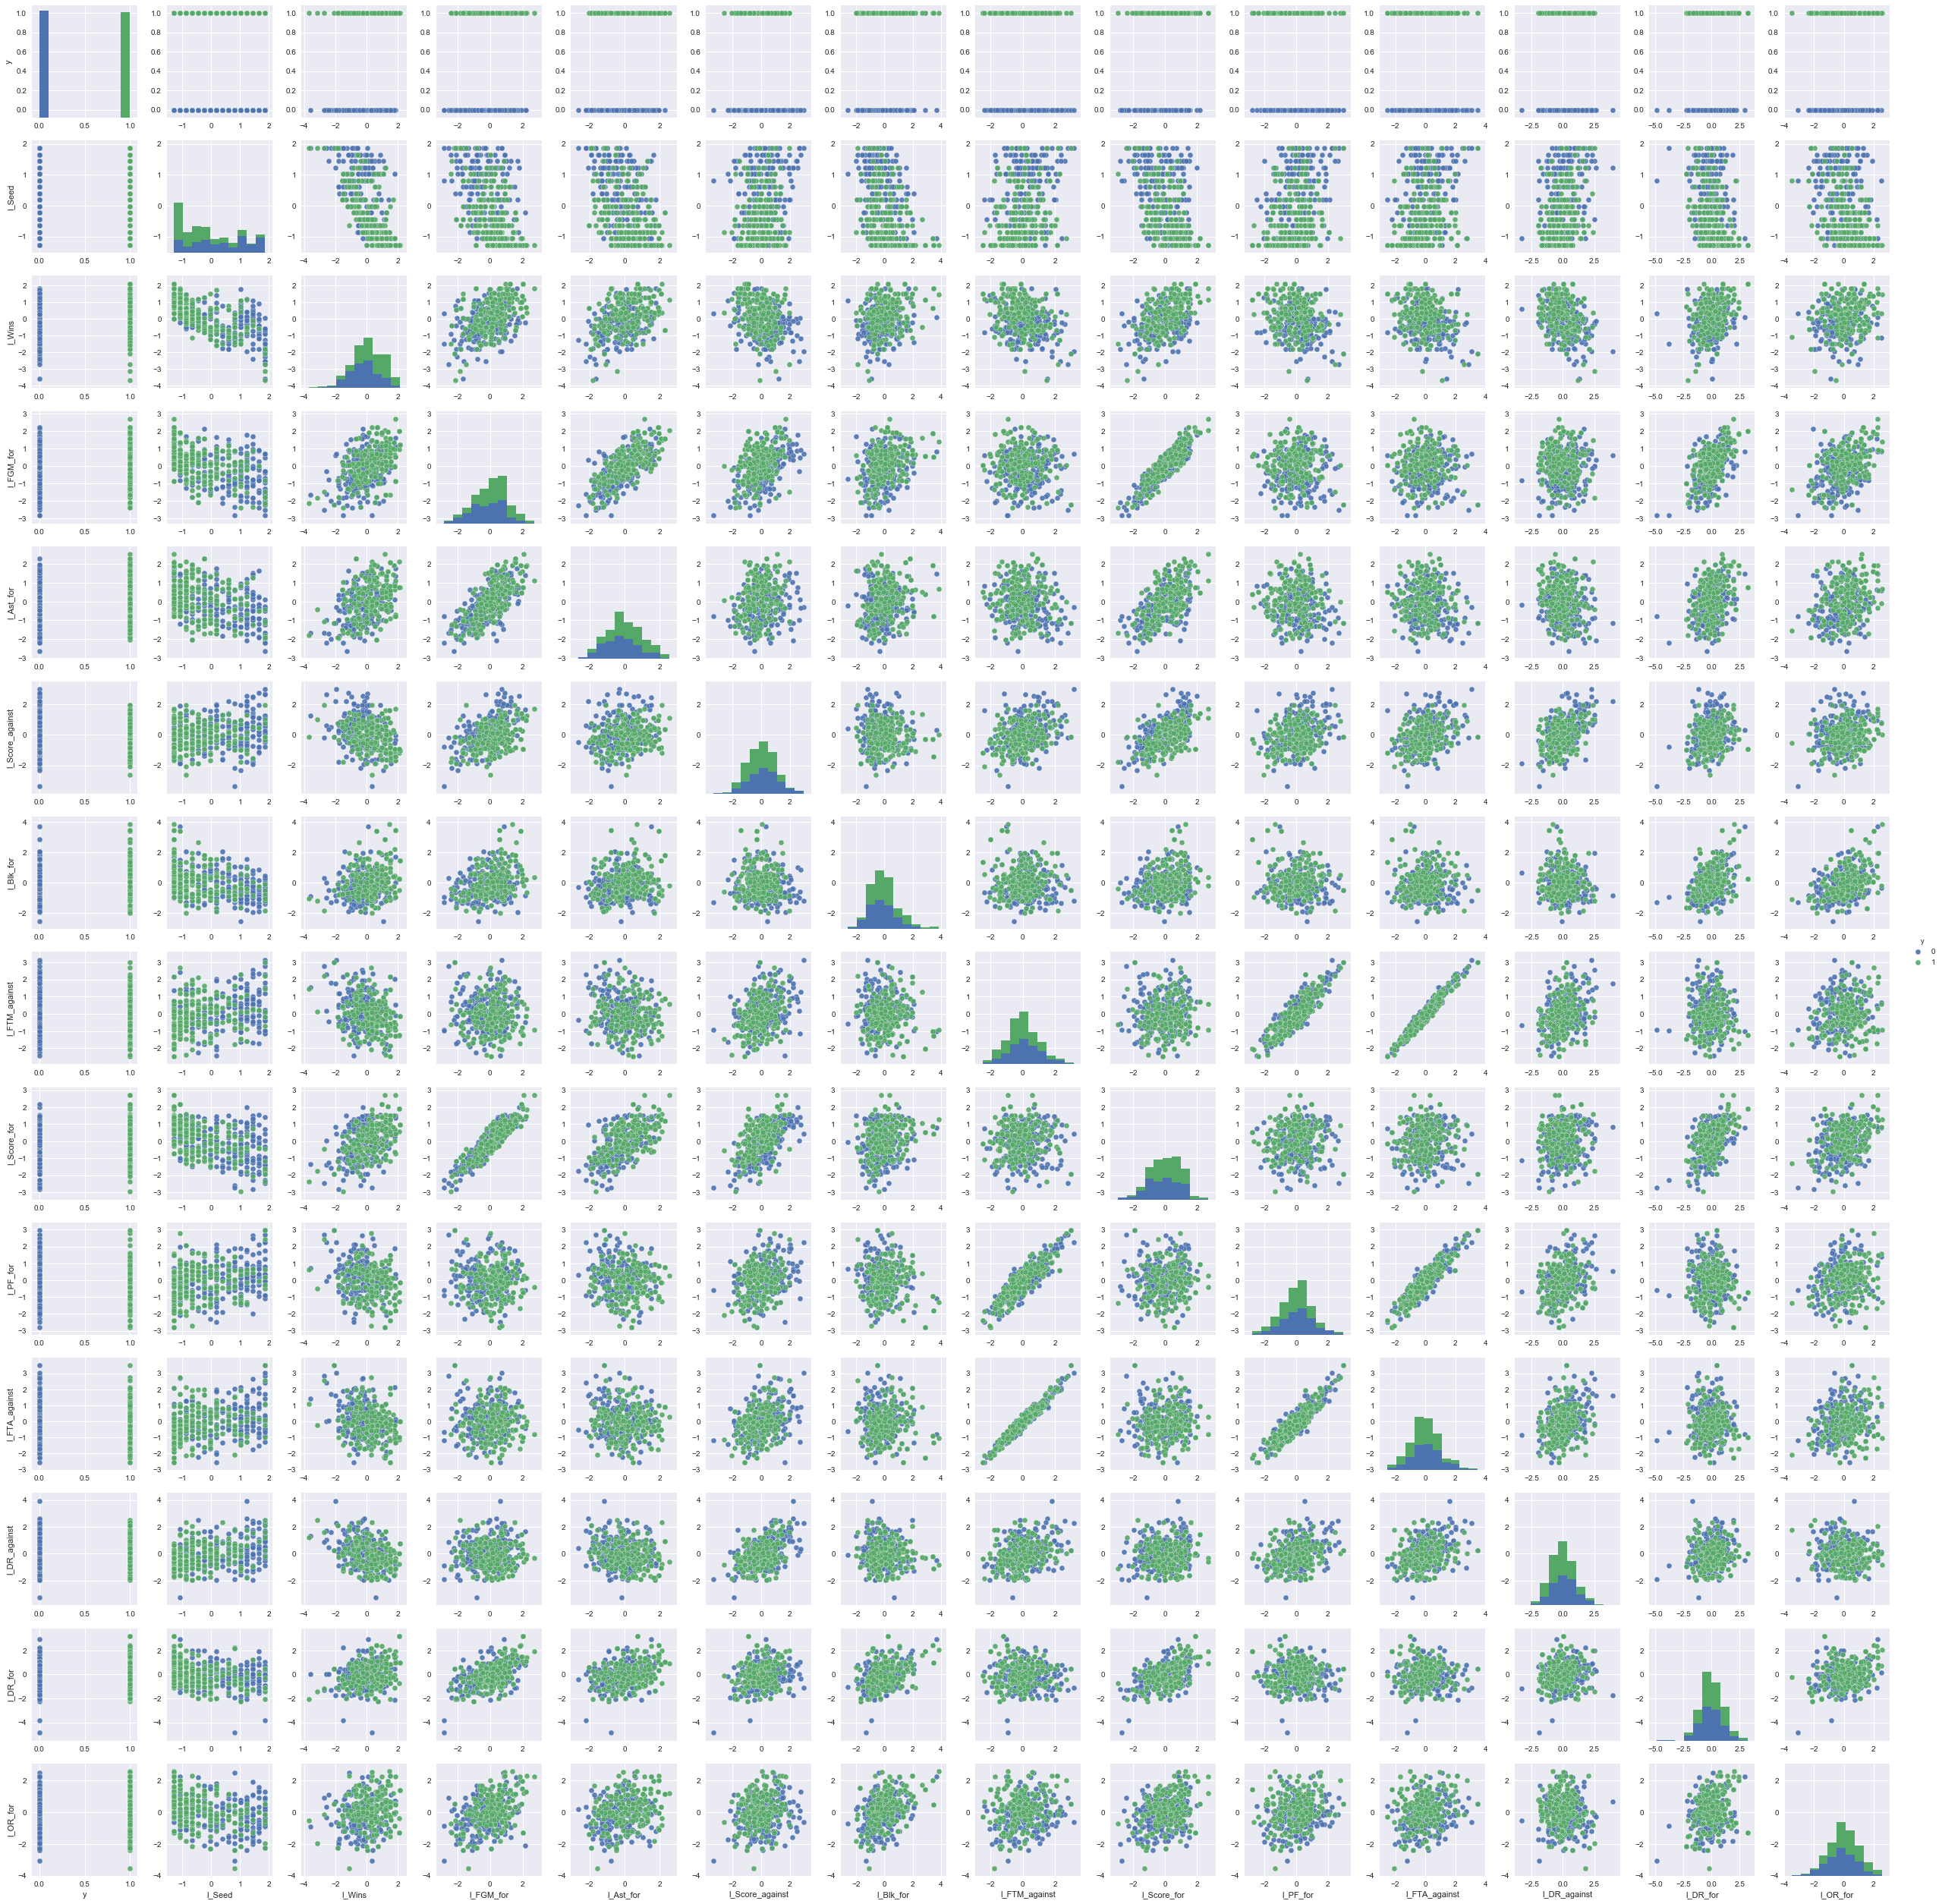

In [72]:
# pairplot of features with highest f-values (excluding ordinal rankings)
features_to_plot = [col[2:] for col in list(post_f_scores.columns) if col.split('_')[0] == 'l']
plot_cols = ['y'] + ['l_' + feat for feat in features_to_plot]

sns.pairplot(post_norm[plot_cols].sample(500), hue='y', plot_kws = {'alpha': 0.9})

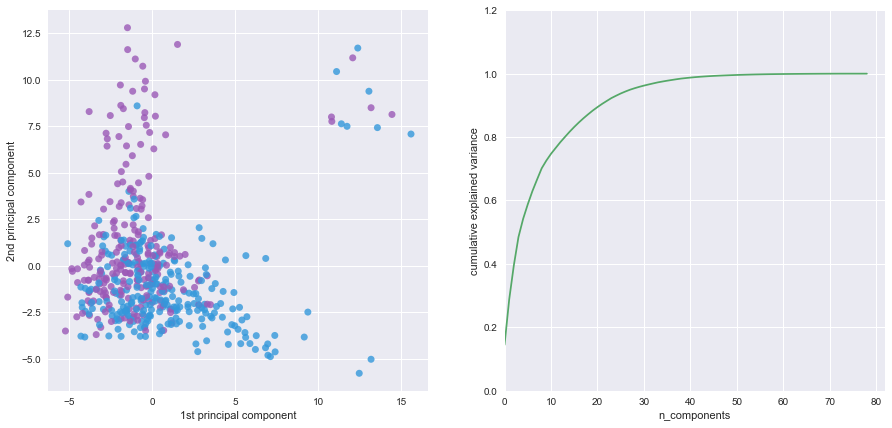

In [28]:
# visualizing separability from first two principal components
X = post_norm.as_matrix(columns=list(post_norm.columns)[2:])
y = post_norm.as_matrix(columns=['y']).ravel()

pca_visualize(X, y)

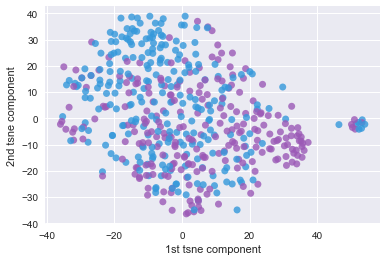

In [29]:
tsne_visualize(X, y)

treating stats from each team as individual features results in poor separation between classifications (probably should have seen this coming)

will attempt to improve separation by using differences in stats betweent teams as features instead

## Using Differences Instead of Individual Stats as Features

In [30]:
d_reg  = individual_to_diff(reg_norm, 'd_reg')
d_post = individual_to_diff(post_norm, 'd_post')

peek(d_post)

df.shape     = (900, 41)


y    d_Wins  d_Score_for  d_Score_against  d_Ast_against  d_Ast_for  \
1518  1  0.424505     0.960813         0.050763      -0.668440   0.831151   
2027  0  0.794530     0.184435        -0.081218      -0.398830   0.796451   
1879  1  1.603529     0.049877        -0.500858      -0.814193   1.725574   
1790  1  2.407364     1.883864         0.055273       0.793169   2.146102   
1644  1 -0.070121    -0.295465        -0.370878       1.120057   1.216943   

      d_Blk_against  d_Blk_for  d_DR_against  d_DR_for    ...       d_Seed  \
1518       0.938368   1.755388      2.261259  1.668298    ...     0.001822   
2027      -0.436326  -1.351202      1.201801  0.256371    ...     1.627174   
1879      -0.901086  -0.942458     -3.124878 -1.636427    ...     1.419657   
1790      -0.064073  -0.995378     -2.831548 -0.174916    ...    -3.241392   
1644      -2.647046  -0.556769     -2.516515  0.174405    ...    -0.249180   

         d_COL     d_DOL     d_MOR     d_POM     d_RPI     d_RTH     d_SAG  \
1518 -0.094057 -0.037531 -0.011719  0.032395 -0.159198 -0.025093 -0.016126   
2027  0.595290  0.819297  1.078788  0.870246  1.389498  0.599936  1.082700   
1879  0.472182  0.363345  1.743295  0.837978  0.963060  0.678547  0.976717   
1790 -3.626132 -3.496332 -4.684197 -3.130882 -3.597181 -3.562146 -3.598161   
1644  0.087573 -0.086343 -0.099472 -0.058179  0.106541 -0.073875  0.012965   

         d_WLK     d_WOL  
1518 -0.040554 -0.047353  
2027  1.071202  0.603500  
1879  0.945319  0.074245  
1790 -3.238313 -3.370299  
1644 -0.024209  0.040400  

[5 rows x 41 columns]

# Data Exploration, With Differences as Features

In [31]:
# dropping ordinal values for f-score analysis
d_ordinal_cols = ['d_' + sys for sys in ordinal_cols]

# show f-scores and p-values
print('Regular Season F-Scores')
display(get_f_scores(d_reg.sample(800).drop(columns=d_ordinal_cols)).head(20).T)

print('Post Season F-Scores')
display(get_f_scores(d_post.sample(800).drop(columns=d_ordinal_cols)).head(20).T)

Regular Season F-Scores


d_Wins   d_Score_for     d_FGM_for  d_Score_against  \
f_score  3.652112e+02  1.304380e+02  1.036679e+02     8.539901e+01   
p_val    1.418496e-68  2.651025e-28  4.071366e-23     1.723043e-19   

            d_Ast_for      d_TO_for  d_Stl_against  d_Ast_against  \
f_score  8.343034e+01  7.734930e+01   6.401936e+01   6.373313e+01   
p_val    4.281247e-19  7.215325e-18   3.789971e-15   4.340539e-15   

         d_DR_against  d_FGM_against     d_FTM_for      d_DR_for  \
f_score  6.163917e+01   5.394102e+01  5.107434e+01  4.663807e+01   
p_val    1.172569e-14   4.634467e-13  1.840328e-12  1.572143e-11   

         d_FTA_against     d_Blk_for  d_FTM_against     d_FTA_for  \
f_score   3.521926e+01  3.520049e+01   3.164277e+01  3.023004e+01   
p_val     4.203816e-09  4.242981e-09   2.475114e-08  5.002418e-08   

         d_PF_against   d_PF_for  d_FGM3_for  d_FGM3_against  
f_score  2.475842e+01  24.000277   18.617150       17.902450  
p_val    7.787556e-07   0.000001    0.000018        0.000026

Post Season F-Scores


d_Seed        d_Wins     d_FGM_for   d_Score_for     d_Blk_for  \
f_score  3.159885e+02  1.398026e+02  8.103202e+01  6.173559e+01  4.414289e+01   
p_val    8.410624e-61  4.395198e-30  1.301152e-18  1.120053e-14  5.286097e-11   

            d_Ast_for     d_FGA_for  d_FTM_against      d_PF_for  \
f_score  3.655298e+01  3.596894e+01   3.332037e+01  3.066448e+01   
p_val    2.176685e-09  2.903256e-09   1.075975e-08  4.028238e-08   

         d_FTA_against      d_TO_for      d_OR_for  d_Score_against  \
f_score   3.061530e+01  2.786789e+01  2.544362e+01        24.236067   
p_val     4.128205e-08  1.629709e-07  5.511754e-07         0.000001   

         d_DR_against   d_DR_for    d_NumOT  d_Stl_for  d_Stl_against  \
f_score     24.106838  19.644163  17.875556  13.345985      10.535523   
p_val        0.000001   0.000010   0.000026   0.000274       0.001214   

         d_Ast_against  d_FGA_against  
f_score       8.843933       6.248679  
p_val         0.003019       0.012606

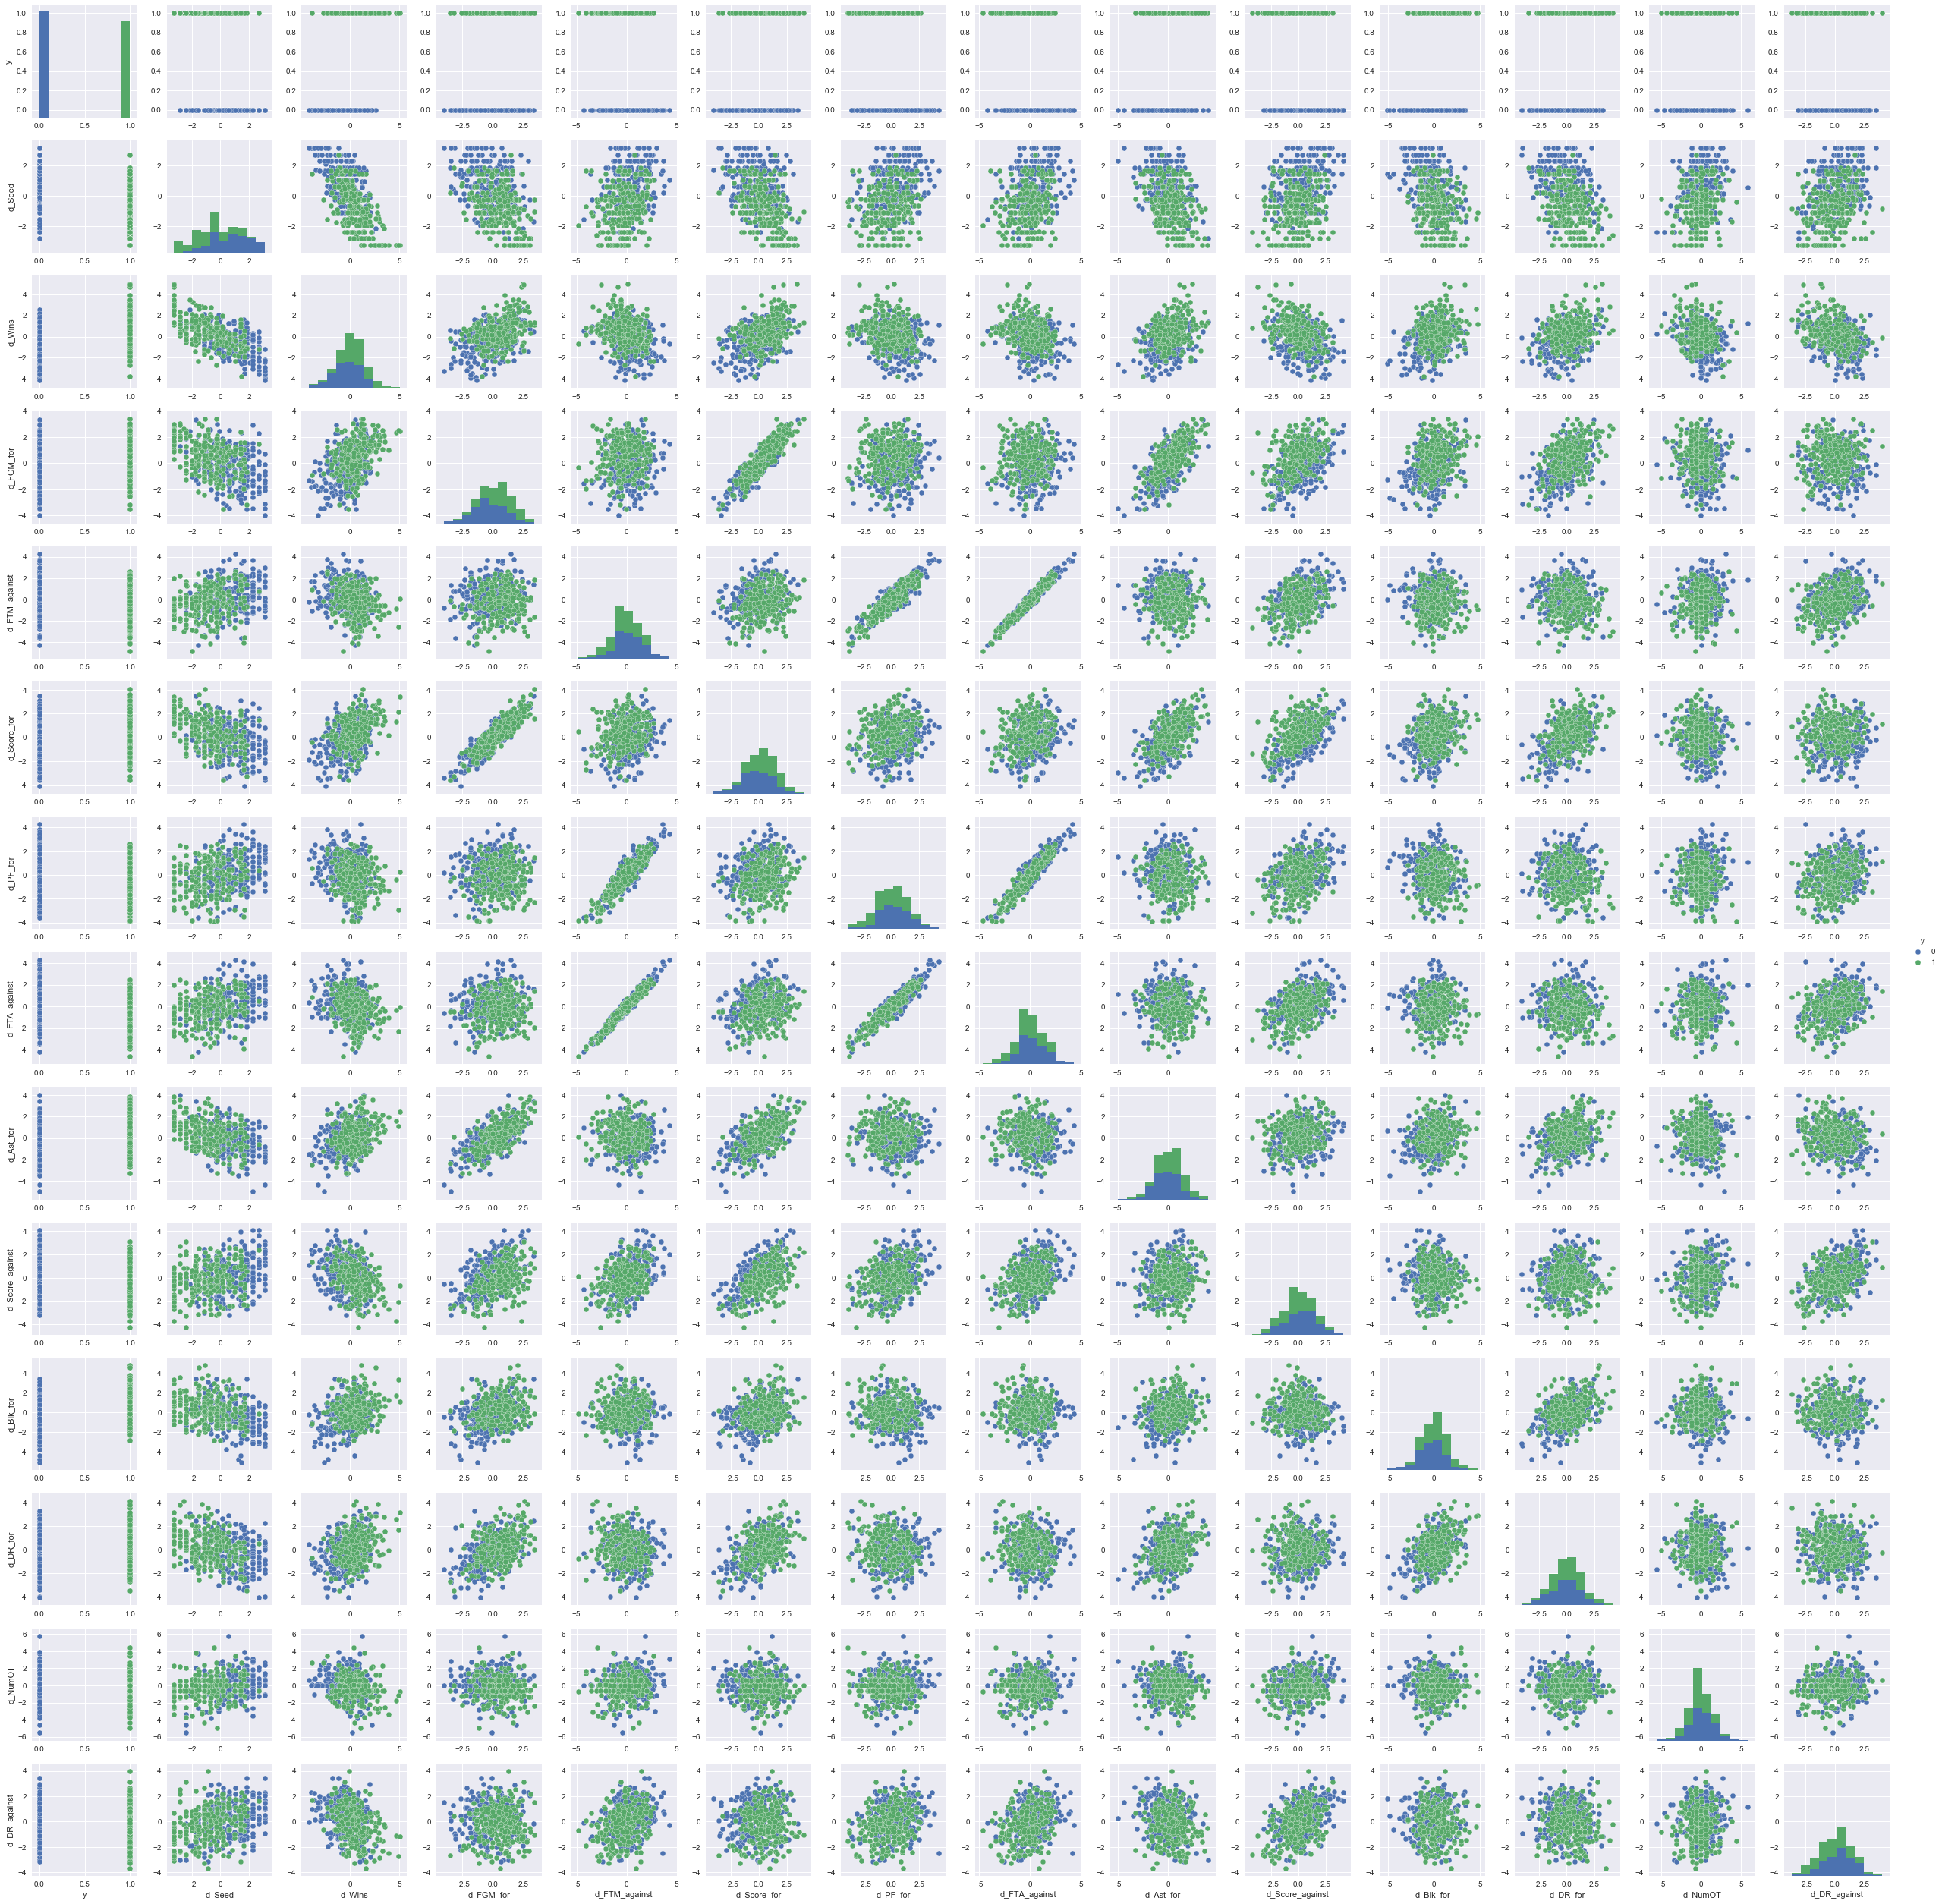

In [32]:
plot_cols = ['y'] + ['d_' + feat for feat in features_to_plot]

sns.pairplot(d_post[plot_cols].sample(500), hue='y')

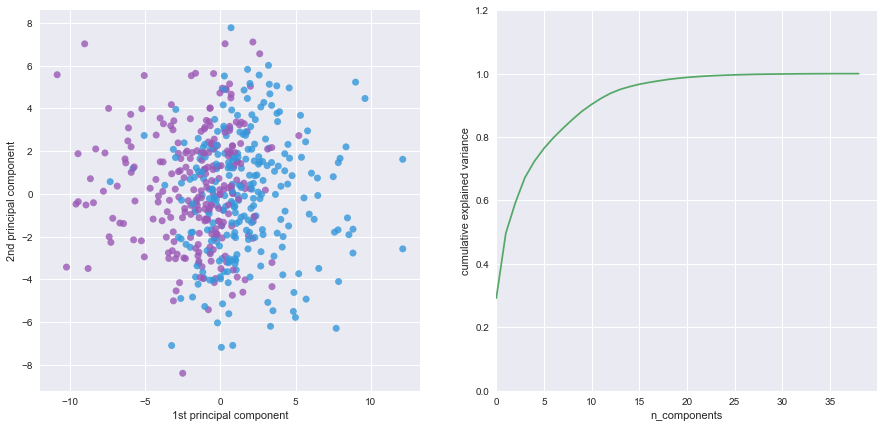

In [33]:
x = d_post.as_matrix(columns=list(d_post.columns)[2:])
y = d_post.as_matrix(columns=['y']).ravel()

pca_visualize(x, y)

separability has improved, but is still somewhat unsatisfying. Doesn't necessarily mean model will perform poorly; the two principal components used only explain ~30% of variance

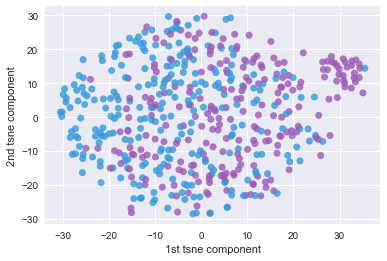

In [34]:
tsne_visualize(x, y)

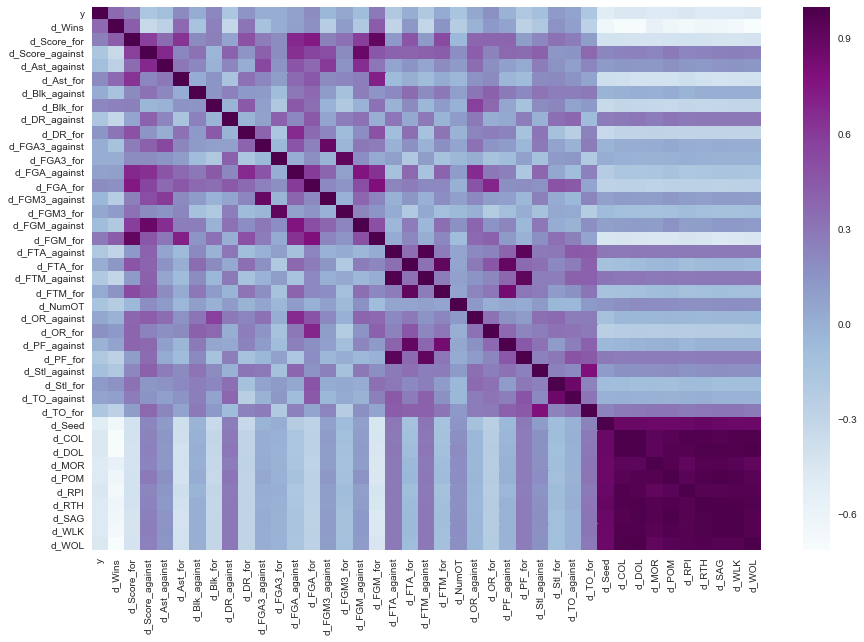

In [35]:
# plot correlation matrix
fig = plt.figure(1, figsize=(15, 10))
fig = sns.heatmap(d_post.corr(), cmap='BuPu')

In [36]:
# see f-scores for ordinal rankings
display(get_f_scores(d_post[['y'] + d_ordinal_cols]))

f_score         p_val
d_MOR  277.266424  1.849758e-54
d_POM  269.004318  4.444068e-53
d_SAG  268.034555  6.463779e-53
d_WLK  265.316088  1.850642e-52
d_RTH  261.299233  8.797124e-52
d_DOL  247.771089  1.746261e-49
d_COL  246.411379  2.982514e-49
d_WOL  242.365082  1.472507e-48
d_RPI  238.950973  5.690329e-48

In [39]:
ordinals_to_remove

['d_COL', 'd_DOL', 'd_POM', 'd_RPI', 'd_RTH', 'd_SAG', 'd_WLK', 'd_WOL']